# Applications In Data Science Semester B 2021 TAU - Final Assignment
## Part 2 - Classification
### Omri Berkovitch

### Overview :
#### This notebook contains my way towards classification of the snacks data sets.
#### I took the following approach :
* Data Sets - Used all of them.
* Data Preperation:
    * Aggregation of the nutrition values per each snack
    * Used some base text cleanings and manipulations algorithms over several text columns 
    * Used Variation of One hot encoder over the Ingredients and Description columns
    * Embedded the Images.
* Model :
    * I have tried the following models: RandomForest, XGBoost, Logistic Regression
        But took the one gave me the best score, XGBoost.
    * Did Parameters Tuning via GridSearchCV
* Appendix's(At the end):
    * Appendix 1 - Contains the code which transformed the Images into tables
    * Appendix 2 - Combining the 3 tabular data sets into one(nutrition, food nutrition, train)
    * Appendix 3 - Parameters Tuning

In [502]:
import string
import pandas as pd
import numpy as np
import pickle
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from rake_nltk import Rake
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

In [503]:
df = pd.read_csv('combined_with_names.csv').drop('Unnamed: 0',axis=1)
df_emb_train = pd.read_csv('embedded_train.csv') # See Appendix 1
df_emb_test = pd.read_csv('embedded_test.csv') # See Appendix 1

In [504]:
print(df.shape, df_emb_train.shape, df_emb_test.shape)

(35276, 55) (31751, 513) (3525, 513)


### Data Prep - Feature Engineering, Cleaning, Aggregations

In [505]:
nut_cols = df.iloc[:,8:].columns

ls1 = df[nut_cols].describe().T[df[nut_cols].describe().T['75%'] == 0].T.columns
ls2 = df[nut_cols].describe().T[df[nut_cols].describe().T['max'] == 100].T.columns

for col in ls1:
    df[col] = np.where((df[col]>0),1,0) # Turns all cols with 75 pct equals 0 to binary
for col in ls2:
    df[col] = df[col]/100 # turn cols to 0-1
    
ls3 = df[nut_cols].describe().T[df[nut_cols].describe().T['max'] == 1].T.columns

combined_ls = list(set(ls1).union(ls2).union(ls3))
temp_df = df.drop(combined_ls,axis=1).iloc[:,8:].describe() # Lets check the columns that left

In [506]:
df[temp_df.columns].quantile(0.97)

Calcium, Ca                      263.00
Iron, Fe                           6.67
Energy                           633.00
Sodium, Na                      1000.00
Cholesterol                       71.00
Fatty acids, total saturated      25.00
Name: 0.97, dtype: float64

In [507]:
df['Iron, Fe'] = np.where((df['Iron, Fe']> 6.67), df['Iron, Fe'].mean(), df['Iron, Fe'])
df['Sodium, Na'] = np.where((df['Sodium, Na']> 1000), df['Sodium, Na'].mean(), df['Sodium, Na'])
df['Cholesterol'] = np.where((df['Cholesterol']> 71), df['Cholesterol'].mean(), df['Cholesterol'])
df['Calcium, Ca'] = np.where((df['Calcium, Ca']> 263), df['Calcium, Ca'].mean(), df['Calcium, Ca'])
df['Fatty acids, total saturated'] = np.where((df['Fatty acids, total saturated']> 25), df['Fatty acids, total saturated'].mean(), df['Fatty acids, total saturated'])

In [508]:
df = pd.merge(df, pd.concat([df_emb_train,df_emb_test]), on='idx', how='left')

### Using nltk Stemmer In order to clean and organize the text columns
##### This is for One hot encoder purposes

In [509]:
# Using stemmer to deal with the long text in ingredients and description
stemmer = PorterStemmer()
stopwords = set(stopwords.words('english'))

def clean_phrase(phrase):
    if phrase is None: 
        return []
    phrase = str(phrase).lower()
    phrase = phrase.translate(str.maketrans('', '', string.punctuation))
    phrase = set(word_tokenize(phrase)).difference(stopwords)
    phrase = set(filter(lambda i: not str.isdigit(i), phrase))
    words = set([stemmer.stem(w) for w in phrase if len(w) > 1])
    return words

In [510]:
df_try = df.drop(['brand', 'household_serving_fulltext','serving_size_unit'], axis=1)
df_try['ing'] = df['ingredients'].apply(clean_phrase)
df_try['desc'] = df['description'].apply(clean_phrase)

In [511]:
df_try['desc'][:5]

0                   {free, gluten, shortbread}
1                {bite, browni, powder, sugar}
2                 {organ, bake, snack, potato}
3                      {organ, einkorn, cooki}
4    {white, bite, tortilla, chip, corn, size}
Name: desc, dtype: object

In [512]:
# Using MultiLabelBinarizer to achieve one hot encoding over column with list of strings

mlb1 = MultiLabelBinarizer()
mlb2 = MultiLabelBinarizer()

ings = mlb1.fit_transform(df_try['ing'])
desc = mlb2.fit_transform(df_try['desc'])

ings_df = pd.DataFrame(ings, columns=mlb1.classes_)
desc_df = pd.DataFrame(desc, columns=mlb2.classes_)

df_try = pd.concat([df_try, ings_df],axis=1)
df_try = pd.concat([df_try, desc_df],axis=1)

df_try = df_try.loc[:, (df_try==0).mean() < .9]
df_try = df_try.drop(['ing', 'ingredients','desc','description'], axis=1)

In [513]:
df_try = df_try.drop('chocol', axis=1)
df_try_test = df_try[~df_try['category'].notna()]
df_try = df_try[df_try['category'].notna()]

### Using XGBOOST Classifier for the final task

In [524]:
params = {'objective': 'multi:softprob', 'base_score': 0.5, 'booster': 'gbtree',
 'colsample_bylevel': 1, 'colsample_bynode': 1,'colsample_bytree': 0.5,
 'gamma': 0.4,'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.300000012,
 'max_delta_step': 0,'max_depth': 7,'min_child_weight': 12, 'monotone_constraints': '()',
 'n_jobs': -1, 'num_parallel_tree': 4, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1,
 'scale_pos_weight': None, 'subsample': 1, 'tree_method': 'exact', 
 'validate_parameters': 1,'verbosity': None, 'verbose': True}

xgb = XGBClassifier(**params)

X_train, X_test, y_train, y_test = train_test_split(df_try.drop(['category', 'idx'], axis=1), 
                                                    df_try.category, test_size = .05,random_state = 30)


In [525]:
xgb.fit(X_train, y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=20)

/Users/omriberkovitch/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:12:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.22493
[1]	validation_0-mlogloss:0.94225
[2]	validation_0-mlogloss:0.76318
[3]	validation_0-mlogloss:0.64007
[4]	validation_0-mlogloss:0.54649
[5]	validation_0-mlogloss:0.47606
[6]	validation_0-mlogloss:0.42123
[7]	validation_0-mlogloss:0.38022
[8]	validation_0-mlogloss:0.34776
[9]	validation_0-mlogloss:0.32161
[10]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=12, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=4,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbose=True,
              verbosity=None)

In [526]:
pd.DataFrame(zip(xgb.feature_importances_,X_train.columns)).sort_values(0,ascending=False)[:10]

,0,1
607,0.044303,chip
608,0.043646,cooki
600,0.029046,water
557,0.027546,flour
2,0.024749,"Iron, Fe"
601,0.021502,wheat
541,0.021108,cocoa
537,0.021024,butter
5,0.018923,Protein
6,0.018676,Total lipid (fat)


Text(0.5, 1.0, 'Confusion Matrix')

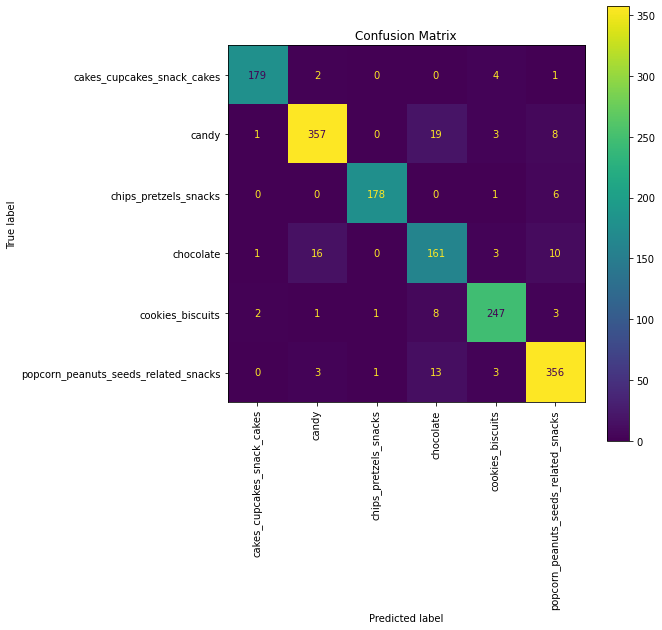

In [527]:
fig, ax = plt.subplots(figsize=(8, 8))
xgb.predict(X_test)
plot_confusion_matrix(xgb,X_test,y_test,ax=ax)
plt.xticks(rotation=90)
plt.title("Confusion Matrix")

In [530]:
accuracy_score(y_true=y_test,y_pred=xgb.predict(X_test))

0.9307304785894207

In [531]:
# Predict on Test and save as Data frame
pd.DataFrame(zip(df_try_test.idx, xgb.predict(df_try_test.drop(['idx','category'],axis=1))),
             columns=['idx','category']).to_csv('model1.csv',index=False)

### Appendix 1 - Embedding the Images

In [ ]:
#!pip install git+https://github.com/openai/CLIP.git
#!pip install pillow
import os
import glob
import torch
import pandas as pd
import numpy as np
import torchvision.transforms as Transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import clip
from PIL import Image
from IPython.display import display

In [ ]:
# Insert train if want to embbed the train images.
path = '/Users/omriberkovitch/Desktop/APPS_IN_DS/final_proj/Final_Project/foods_final/test'
img_files = [f for f in os.listdir(path) if f.endswith('.jpg')]
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, clip_preproccess = clip.load('ViT-B/32',device)
clip_model.eval()
img_files

In [ ]:
data = []
for i,img in enumerate(img_files):
  img_id = int(img.split('.')[0])
  f_path = f"{path}/{img}"
  encode_img = list(clip_model.encode_image(clip_preproccess(Image.open(f_path)).unsqueeze(0).to(device)).cpu().detach().numpy()[0])
  encode_img = [img_id] + encode_img
  data.append(encode_img)

print(data)
df = pd.DataFrame(data, columns=[f"{i}" for i in range(513)])

### Appendix 2 - Merging data sets

In [ ]:
# Load data sets
df_food_n = pd.read_csv('data/food_nutrients.csv')
df_nut = pd.read_csv('data/nutrients.csv')
df_train = pd.read_csv('data/food_train.csv')
df_test = pd.read_csv('data/food_test.csv')
categories = df_train['category'].unique()

In [ ]:
df_all = pd.concat([df_test,df_train]) # concat the train and test
merged = pd.merge(df_food_n,df_all,on='idx')
df_merged = pd.merge(merged,df_nut, on='nutrient_id')
cols = ['idx', 'nutrient_id','name', 'unit_name', 'amount', 
        'brand', 'description', 'ingredients',
       'serving_size', 'serving_size_unit', 'household_serving_fulltext',
       'category']
df_merged = df_merged[cols]
lst_of_nut = df_merged['nutrient_id'].unique()
d = dict(zip(df_nut['nutrient_id'],df_nut['name']))

In [ ]:
df_all = pd.concat([df_test,df_train]) # concat the train and test

# Create new colomuns for nutrient id
for col in lst_of_nut:
    df_all[col] = 0
# Sort data frame by the index
df_all.sort_values(by='idx')
indexes = set(df_all['idx'])
sorted(indexes)

# Create df with all columns as nutrients and assign the value to each snack
for food_id in indexes:
    cpy = df_food_n[df_food_n['idx'] == food_id]
    dc = dict(zip(cpy['nutrient_id'],cpy['amount']))
    for item in dc.items():
        df_all.loc[df_all['idx'] == food_id, item[0]] = item[1]

# Rename the cols with nutrient id to it's truly name
d = {str(key): value for key,value in d.items()}
df_all.rename(columns=d,inplace=True)
df_all.to_csv('combined_with_names.csv',index=False)

### Appendix 3 - Parameters Tuning

In [ ]:
xgb = XGBClassifier(n_jobs=-1, verbose=True)
parameters = {
 "max_depth"        : [5,7],
 "min_child_weight" : [3,5,12],
 "gamma"            : [0.4,0.8,1.3],
 "colsample_bytree" : [0.5,0.8]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)


In [ ]:
xgb_best = xgb_grid.best_estimator_
accuracy_score(y_true=y_test,y_pred=xgb_best.predict(X_test))

In [119]:
pickle.dump(xgb_best, open('Optimized_XGB_MODEL.pkl', 'wb'))
xgb_best.get_xgb_params()